**Roboflow에서 당구공(Red, White, Yellow) 데이터셋을 만든 후(labelling 포함), pretrained YOLO를 학습**

- Google colab에서 진행

https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb#scrollTo=CjpPg4mGKc1v

In [ ]:
!nvidia-smi

Wed Nov 27 08:59:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

### CLI로 YOLO 써보기 with Pretrained COCO Model
```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.25M/6.25M [00:00<00:00, 67.3MB/s]
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs

100% 104k/104k [00:00<00:00, 41.5MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 57.7ms
Speed: 12.7ms preprocess, 57.7ms inference, 1435.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


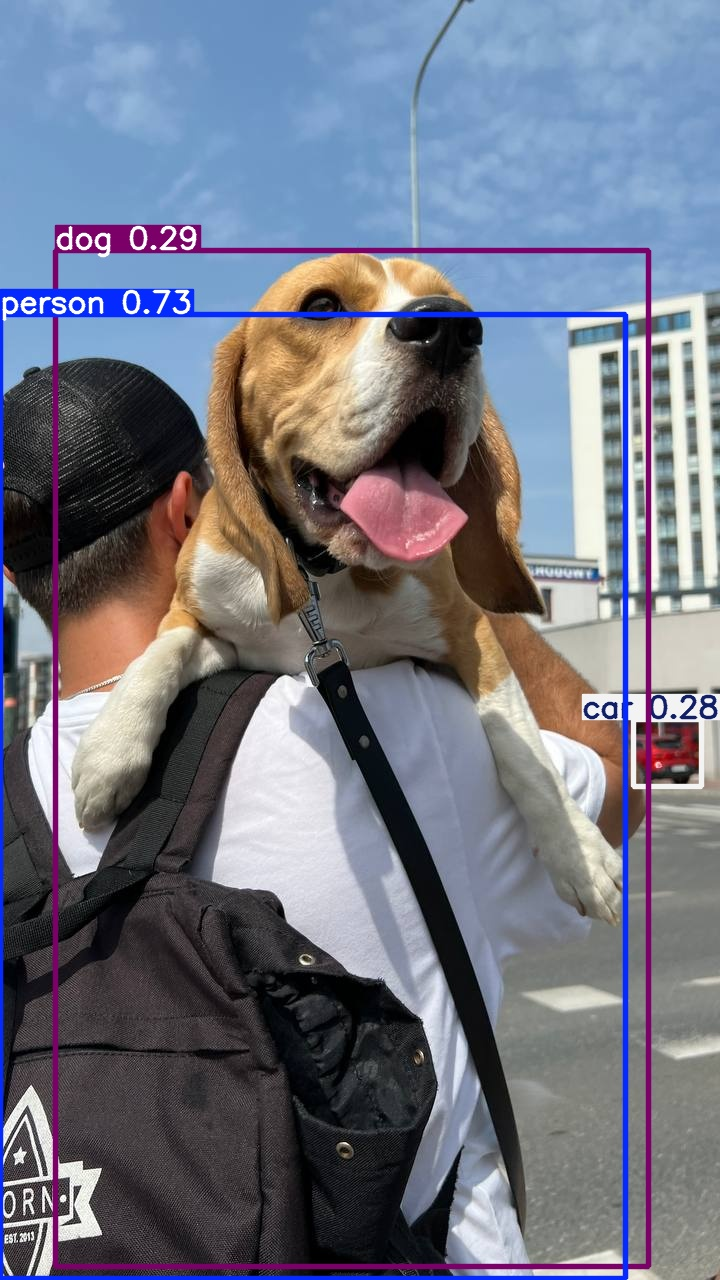

In [ ]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

In [ ]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', save=True)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 46.3ms
Speed: 2.6ms preprocess, 46.3ms inference, 678.4ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict2


In [ ]:
results[0].boxes.xyxy

tensor([[   0.0000,  314.4717,  625.0754, 1278.1946],
        [  55.1731,  250.0220,  648.1080, 1266.2720],
        [ 633.2291,  719.5391,  701.0538,  786.0336]], device='cuda:0')

In [ ]:
results[0].boxes.conf

tensor([0.7271, 0.2907, 0.2846], device='cuda:0')

In [ ]:
results[0].boxes.cls

tensor([ 0., 16.,  2.], device='cuda:0')

# **Roboflow로 만든 데이터셋으로 Train!**

In [ ]:
!rm -rf {HOME}/runs/detect/*

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="key_is_secret")
project = rf.workspace("my_workspace").project("4-ball-billiard")
version = project.version(2)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 4-ball-Billiard-2 in yolov8:: 100%|██████████| 522/522 [00:00<00:00, 7562.45it/s]


In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.pt data=/content/4-ball-Billiard-2/data.yaml epochs=400 imgsz=1024 plots=True pretrained=True

/content
100% 6.25M/6.25M [00:00<00:00, 192MB/s]
New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/4-ball-Billiard-2/data.yaml, epochs=400, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cla

/content


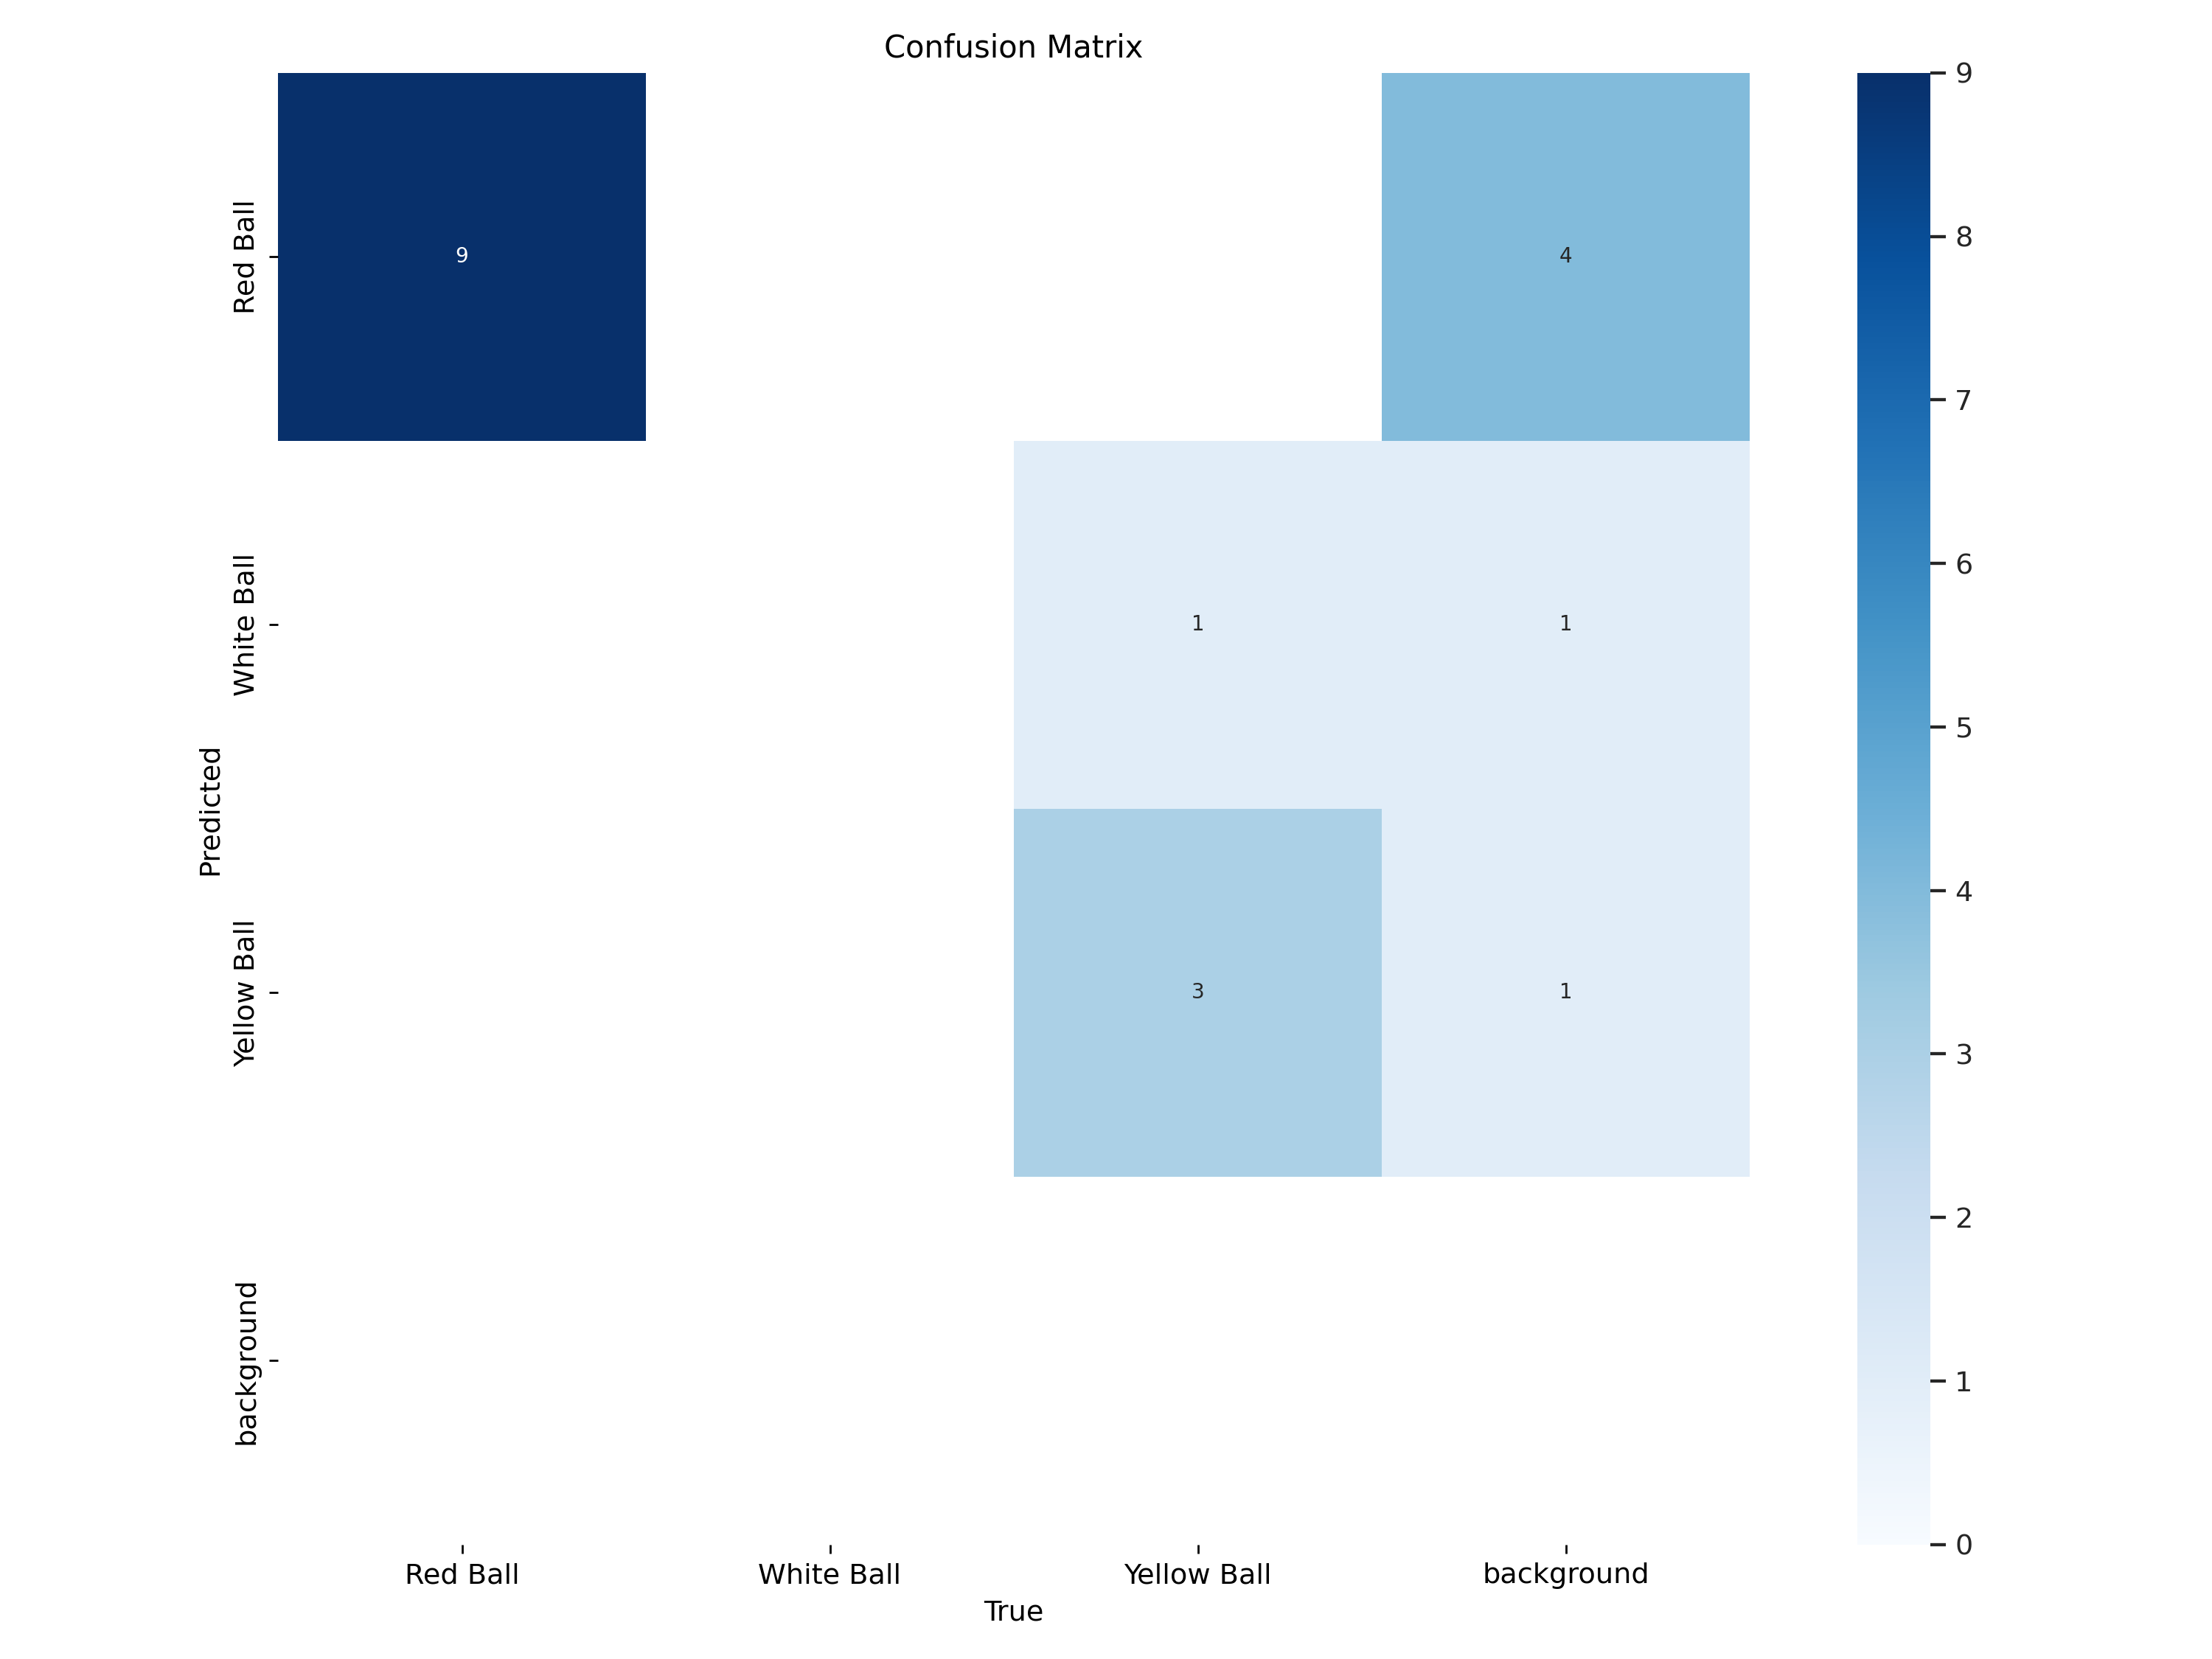

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


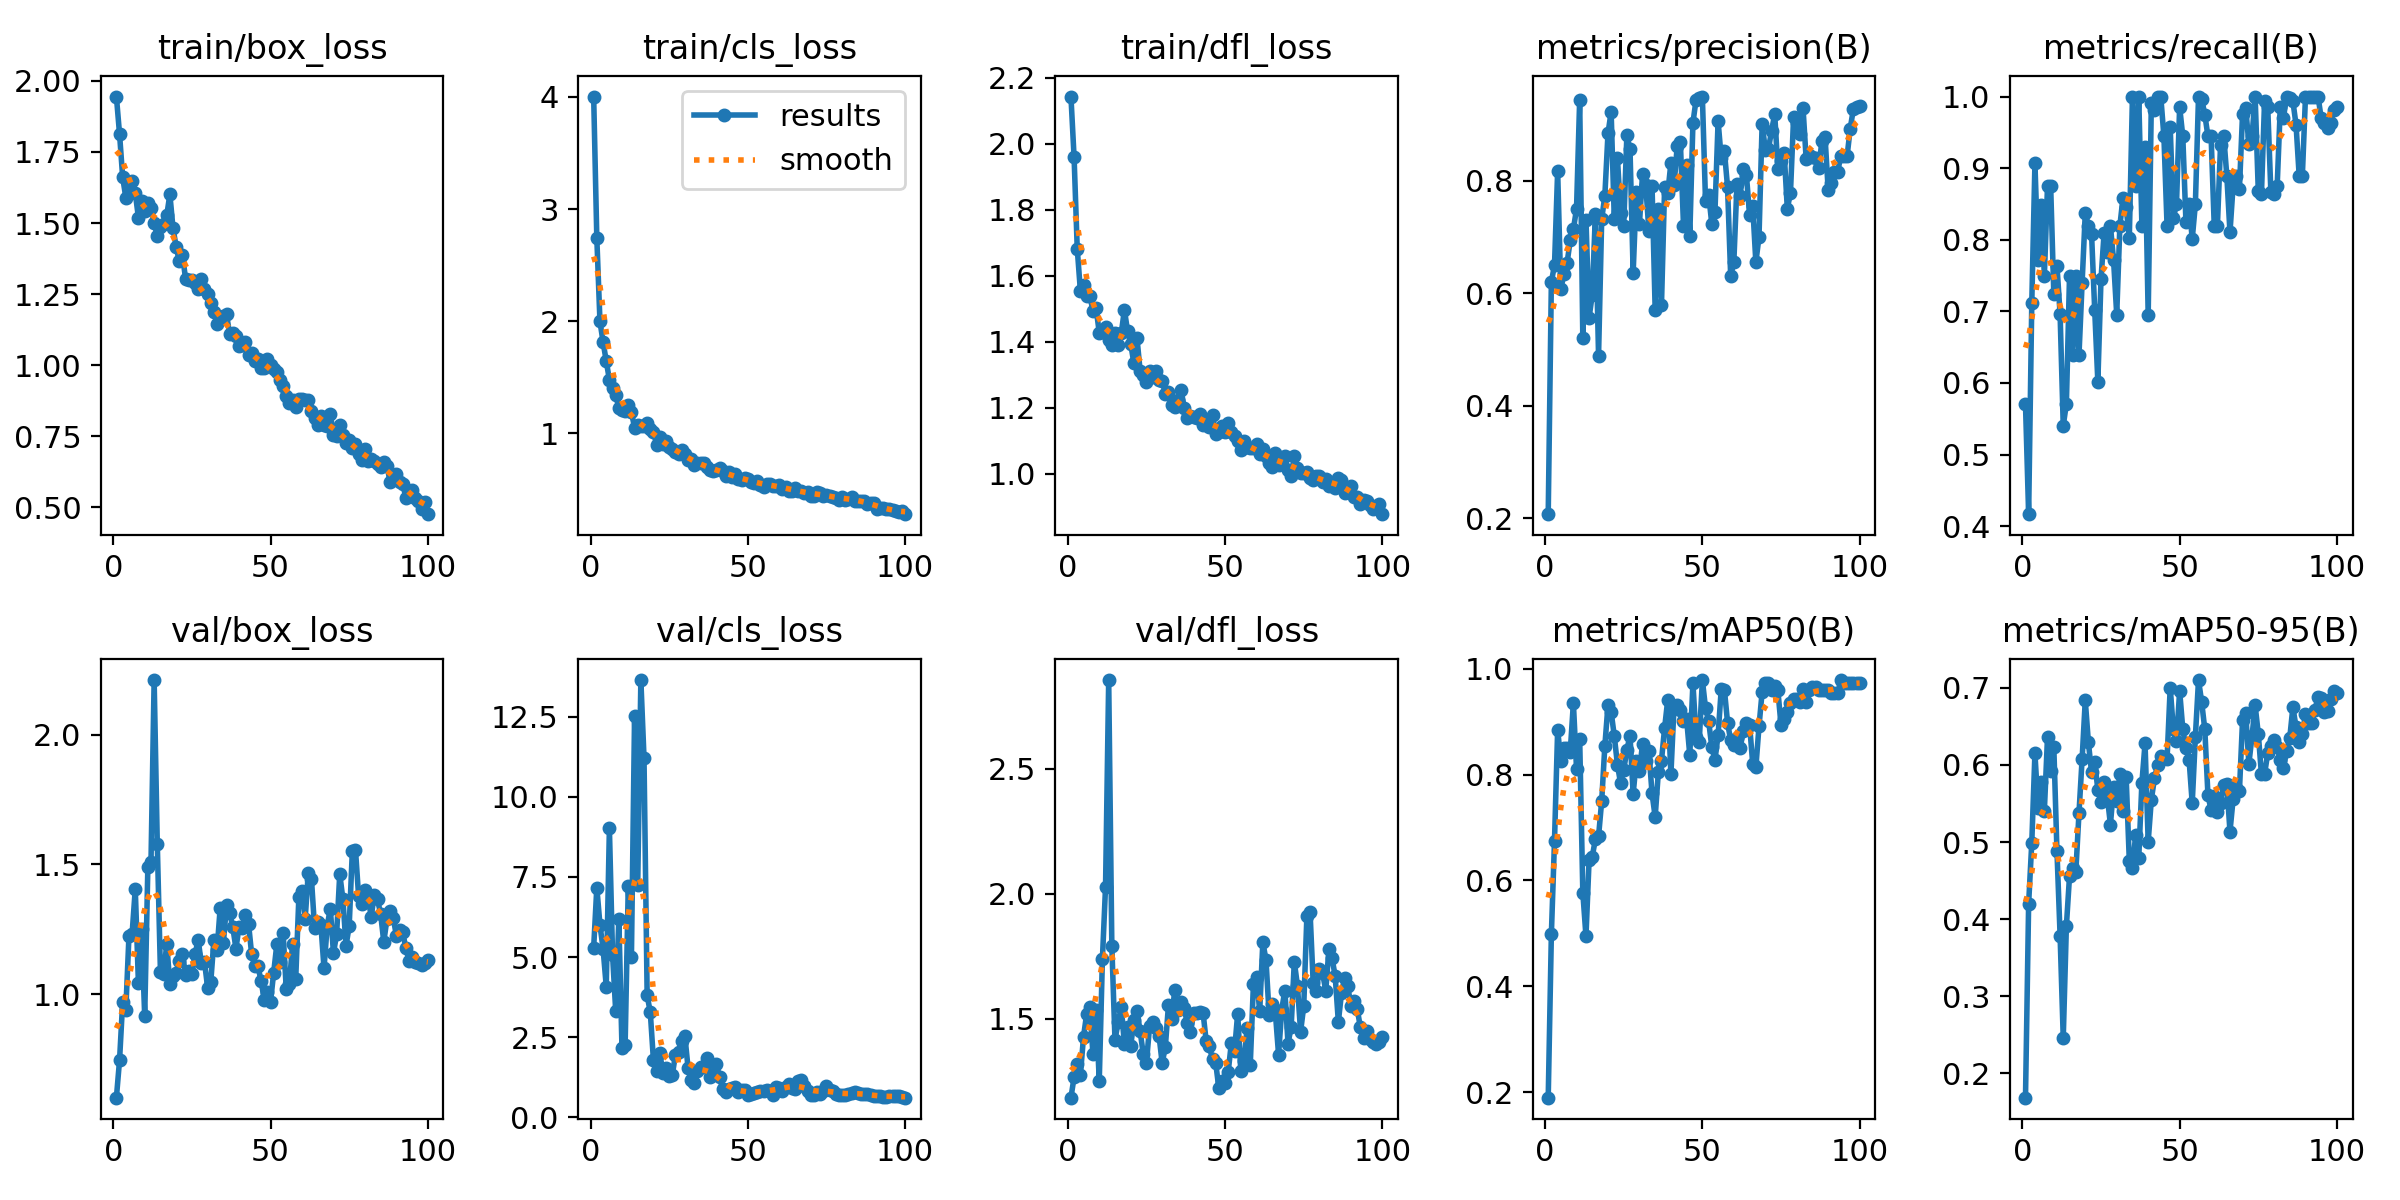

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


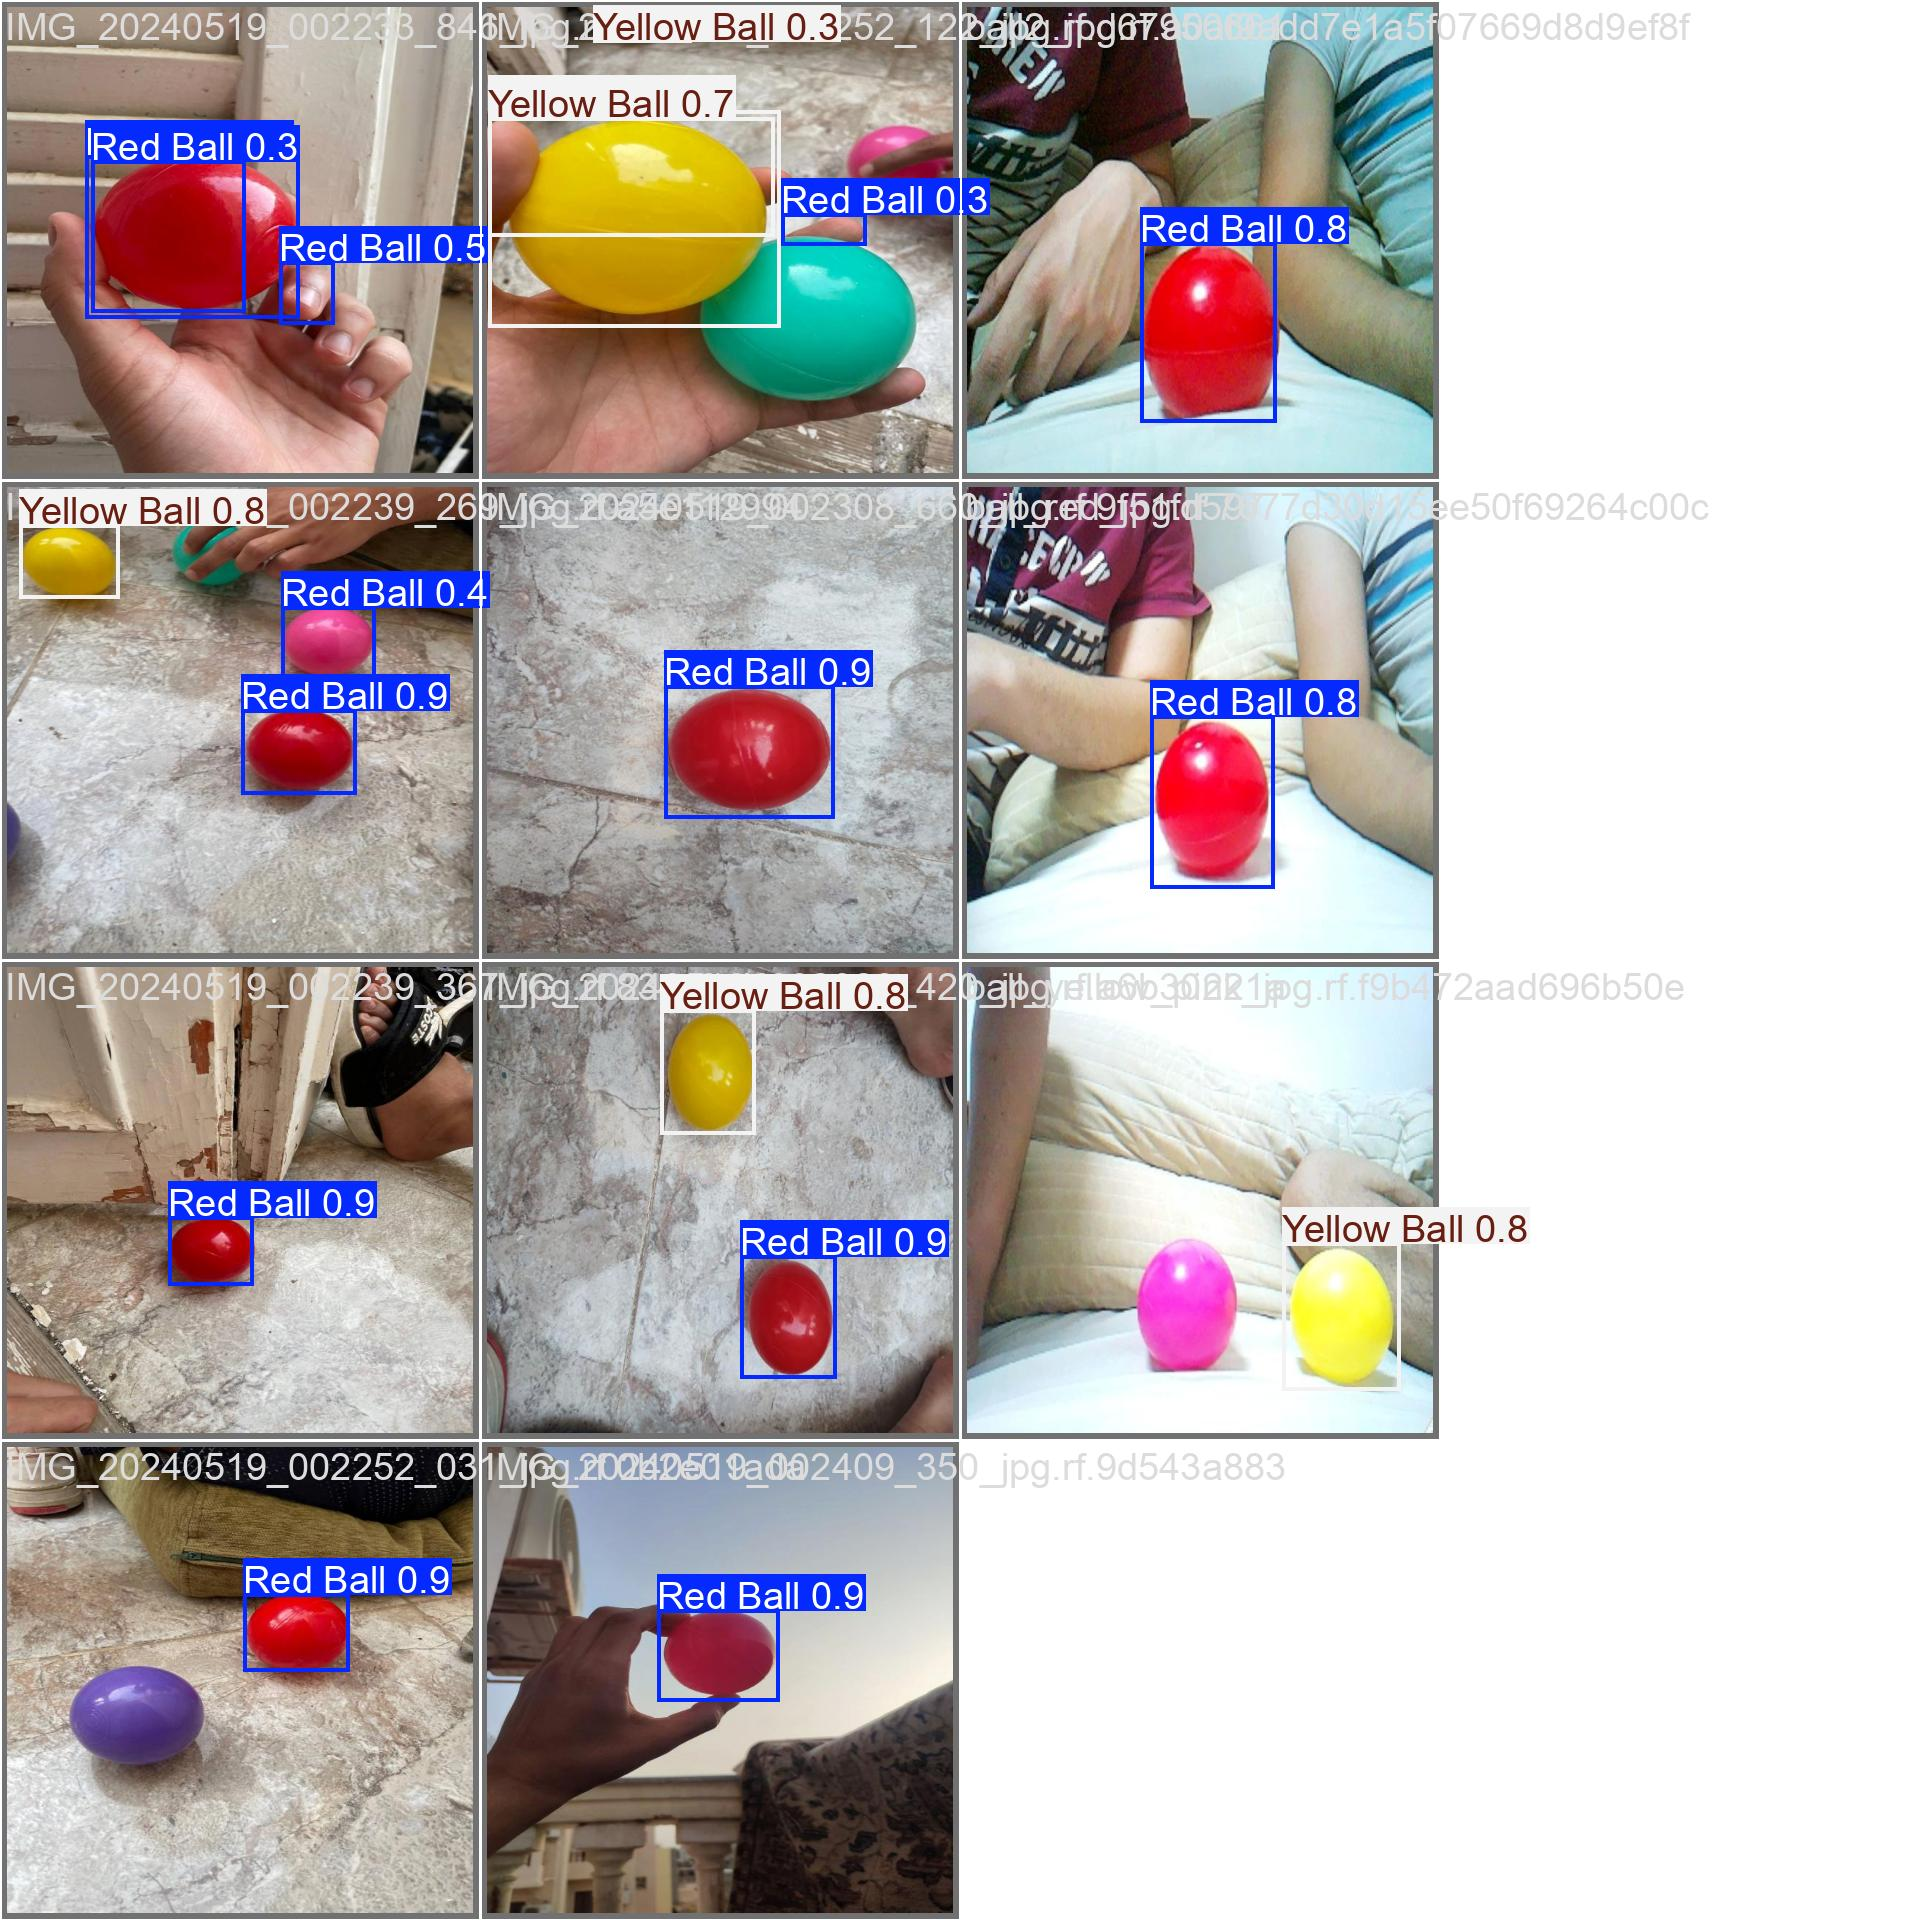

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_labels.jpg', width=600)
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=/content/4-ball-Billiard-2/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/4-ball-Billiard-2/valid/labels.cache... 11 images, 0 backgrounds, 0 corrupt: 100% 11/11 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:01<00:00,  1.11s/it]
                   all         11         13      0.967      0.968      0.995      0.809
              Red Ball          9          9          1      0.936      0.995      0.845
           Yellow Ball          4          4      0.935          1      0.995      0.772
Speed: 0.6ms preprocess, 26.7ms inference, 0.0ms loss, 52.5ms postprocess per image
Results saved to runs/detect/val3
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/4-ball-Billiard-2/test/images save=True

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs

image 1/10 /content/4-ball-Billiard-2/test/images/20_jpg.rf.8a715565a2539d5e055ed29cd1178a10.jpg: 1024x1024 1 White Ball, 2 Yellow Balls, 32.6ms
image 2/10 /content/4-ball-Billiard-2/test/images/30_jpg.rf.37851cc92782457d09ece17cc38d5ddb.jpg: 1024x1024 3 Red Balls, 2 White Balls, 2 Yellow Balls, 32.7ms
image 3/10 /content/4-ball-Billiard-2/test/images/33_jpg.rf.e6a7239ac6db5c2ffbd63e0fbb8cec0d.jpg: 1024x1024 2 Red Balls, 1 White Ball, 2 Yellow Balls, 32.6ms
image 4/10 /content/4-ball-Billiard-2/test/images/354_jpg.rf.bec954def5bcf8da6acaf628ef0be5bc.jpg: 1024x1024 3 Red Balls, 32.6ms
image 5/10 /content/4-ball-Billiard-2/test/images/556_jpg.rf.48b88febd6329abb037f860ccac69db9.jpg: 1024x1024 2 Red Balls, 1 White Ball, 1 Yellow Ball, 32.6ms
image 6/10 /content/4-ball-Billiard-2/test/images/808_jpg.rf.573c105f6

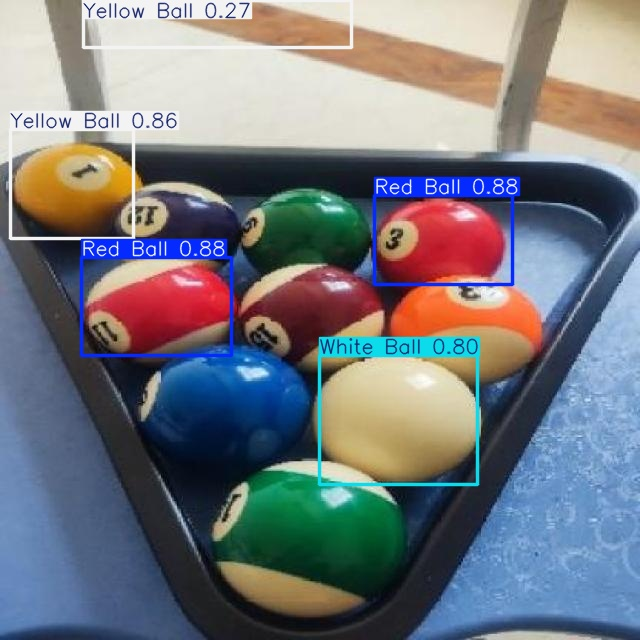

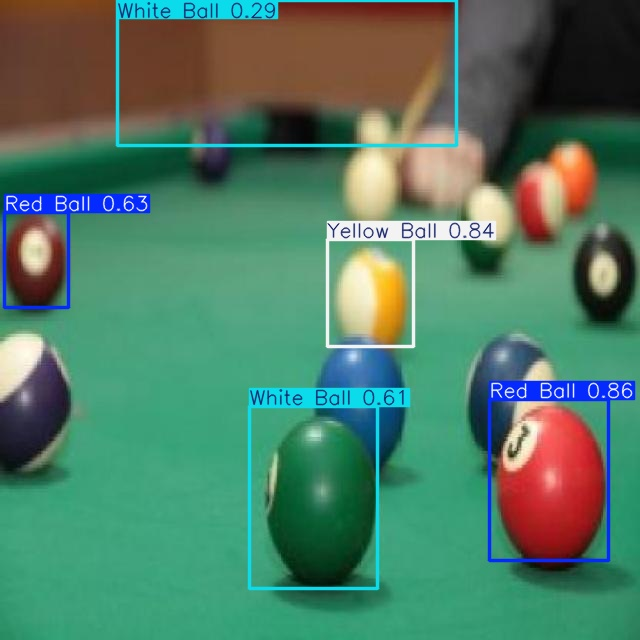

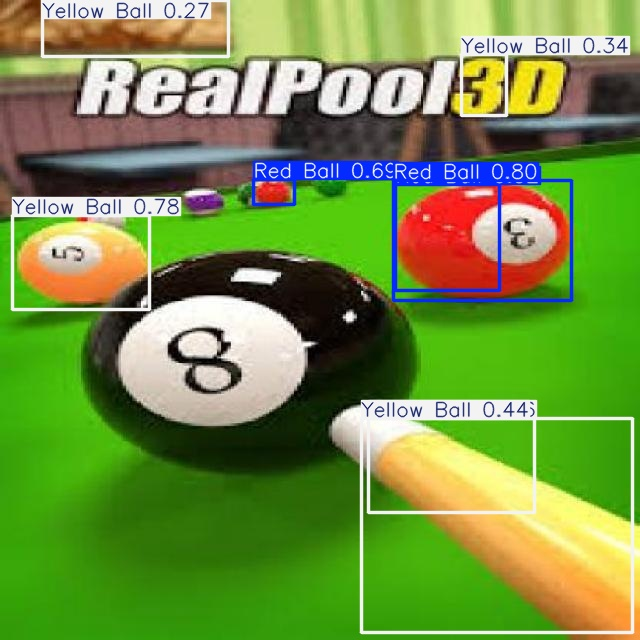

In [ ]:
import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/content/runs/detect/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:3]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train2/")

Dependency ultralytics==8.0.196 is required but found version=8.2.103, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/superpsy/4-ball-billiard/1
Share your model with the world at: https://universe.roboflow.com/superpsy/4-ball-billiard/model/1
